In [ ]:
# Download all the necessary packages
!pip install plotnine
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

# **Importing the necessary packages**

In [ ]:
import pandas as pd
from scipy import stats
from plotnine import ggplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# **Let's read the dataset**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DataScience/data_banknote_authentication.txt', sep=",", header=None)
data.columns = ["Variance", "Skewness", "Kurtosis", "Entropy", 'Output']
data

,Variance,Skewness,Kurtosis,Entropy,Output
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


The dataset contains these four input characteristics:


*   The **variance** of the image transformed into wavelets. 
*   The **asymmetry** of the image transformed into wavelets. 
*   The **Kurtosis** of the image transformed into wavelets.
*   Image **entropy**

The target value is simply **0 for real** banknotes and **1 for fake** banknotes. 

# **Data Exploration**

**Summarizing Missing Values**

In [ ]:
data.isnull().sum()

Variance    0
Skewness    0
Kurtosis    0
Entropy     0
Output      0
dtype: int64

We have no missing values ​​in the data.

## **Now let’s check if our data is balanced against the target values:**

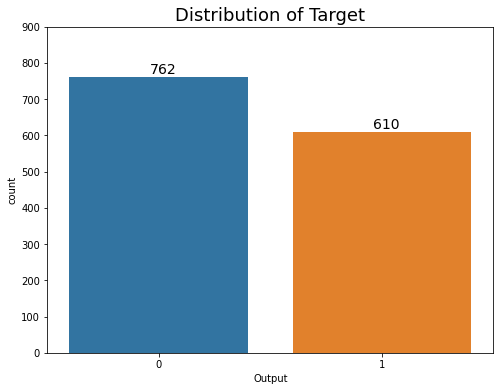

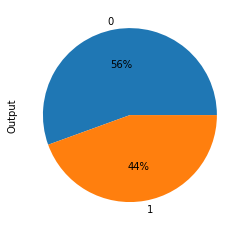

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Target', size=18)
sns.countplot(x=data['Output'])
target_count = data.Output.value_counts()
plt.annotate(s=target_count[0], xy=(-0.04,10+target_count[0]), size=14)
plt.annotate(s=target_count[1], xy=(0.96,10+target_count[1]), size=14)
plt.ylim(0,900)
plt.show()

	
data['Output'].value_counts().plot(kind='pie', autopct='%1.0f%%')

The dataset appears to be partially balanced

Correlation:
Output      1.000000
Kurtosis    0.155883
Entropy    -0.023424
Skewness   -0.444688
Variance   -0.724843
Name: Output, dtype: float64


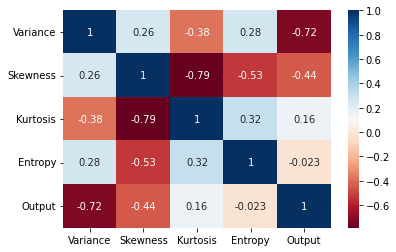

In [ ]:
# Check correlation between the features
print('Correlation:')
print(data.corr()['Output'].sort_values(ascending=False))
sns.heatmap(data.corr(), annot=True, cmap="RdBu")
plt.show()

It can be obseved that some features do have correlation between them. 

# **Below is a pair diagram to get an overview of the relationship between all the entities.**

The plots are in matrix format where the row name represents x-axis and column name represents the y-axis. The main-diagonal subplots are the univariate histograms (distributions) for each attribute.

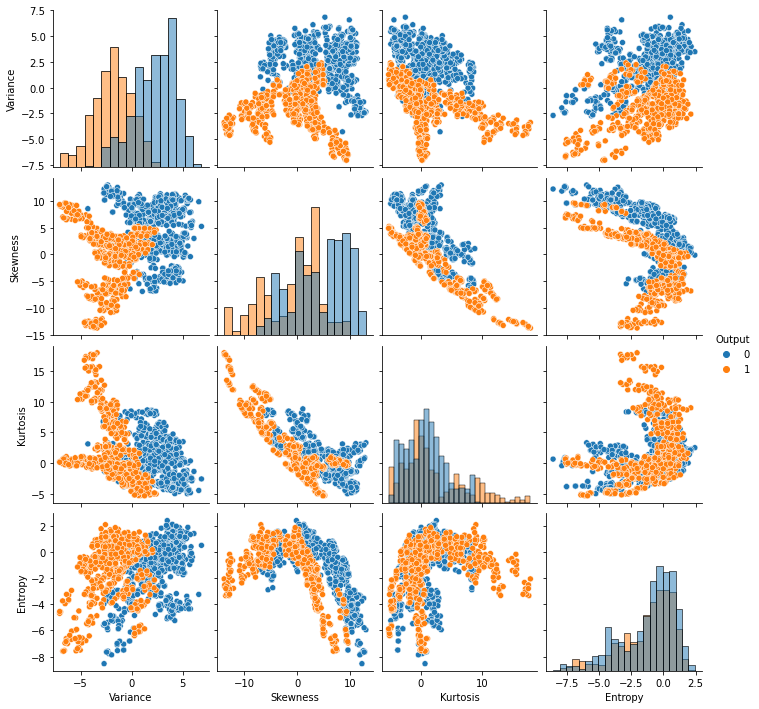

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue='Output', diag_kind="hist")
plt.show()

**Observations:**


*   The distribution of both variance and skewness appears to be quite different for the two target characteristics, while kurtosis and entropy appear to be more similar.

*  There are clear linear and nonlinear trends in the input features.
*   Some characteristics seem to be correlated.

*   Some features seem to separate genuine and fake banknotes quite well.



# **Basic Stats of the dataset:**


In [ ]:
df = data.iloc[:, :-1]
df.describe()

,Variance,Skewness,Kurtosis,Entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


The statistics includes the summarization of the central tendency, dispersion and shape of a dataset’s distribution.

The describe() method result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles.

##Mean
The mean value is the average value. It's the sum of all values, and divided the sum by the number of values.

##Standard Deviation
It describes how spread out the values are. Here, the standard deviation values are higher. A higher standard deviation indicates that the values are spread out over a wider range.

##Min
The minimum value of that series.

##Percentile
This shows how many of the values are less than the given percentile. Its default value is [.25, .5, .75], which returns the 25th, 50th, and 75th percentiles.

# **Data Processing**

In [ ]:
# split the dataset into training, validation and testing
# shuffled the Dataframe by using Pandas 'sample' method
# by passing in frac=0.8, it instructs Pandas to return 80% of the dataframe.
training_data = data.sample(frac=0.8, random_state=25)
_ = data.drop(training_data.index)

# the remaining 20% of the dataset divided equally into 10% validation and 10% testing
validation_data = _.sample(frac=0.5, random_state=25)
testing_data = _.drop(validation_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of validation examples: {validation_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 1098
No. of validation examples: 137
No. of testing examples: 137


In [ ]:
# Prepare training set
Variance = training_data['Variance']
Skewness = training_data['Skewness']
Kurtosis = training_data['Kurtosis']
Entropy = training_data['Entropy']
labels = training_data['Output']

train_features = list(zip(Variance,Skewness,Kurtosis,Entropy))

# As observed, the values had lot of variations
# Normalizing the data before training
scaler = MinMaxScaler()
scaler.fit(df)
train_features = scaler.transform(train_features)
train_features

array([[0.29877622, 0.49275988, 0.33991427, 0.90253417],
       [0.86380518, 0.79992292, 0.12678829, 0.69970812],
       [0.39333954, 0.26813772, 0.47766601, 0.80599853],
       ...,
       [0.75962904, 0.83608048, 0.09707713, 0.72345854],
       [0.69634165, 0.81502131, 0.0672152 , 0.65843767],
       [0.74150675, 0.37661414, 0.45518771, 0.81481673]])

In [ ]:
#Prepare validation set
Variance_val = validation_data['Variance']
Skewness_val = validation_data['Skewness']
Kurtosis_val = validation_data['Kurtosis']
Entropy_val = validation_data['Entropy']
labels_val = validation_data['Output']

validation_features = list(zip(Variance_val,Skewness_val,Kurtosis_val,Entropy_val))
validation_features = scaler.transform(validation_features)
validation_features

array([[0.32505463, 0.4864107 , 0.37246861, 0.7774271 ],
       [0.32097296, 0.51142052, 0.28284834, 0.87196414],
       [0.65316689, 0.58451545, 0.36287505, 0.81622794],
       [0.79169101, 0.89562465, 0.06300644, 0.41199524],
       [0.58706704, 0.53929511, 0.48571305, 0.72428144],
       [0.45482408, 0.58033205, 0.16336614, 0.67195868],
       [0.63281627, 0.66333766, 0.02347341, 0.54979678],
       [0.67292618, 0.65505319, 0.2549077 , 0.74109496],
       [0.79075352, 0.39388281, 0.37667736, 0.85338298],
       [0.3588329 , 0.52171849, 0.18440563, 0.70182402],
       [0.85594473, 0.63019604, 0.25727012, 0.85067878],
       [0.46816664, 0.62260755, 0.156689  , 0.55614356],
       [0.34808068, 0.96298929, 0.23109992, 0.06936905],
       [0.6414844 , 0.74533671, 0.27155319, 0.59176919],
       [0.39280589, 0.26945485, 0.43315312, 0.69147731],
       [0.36786881, 0.1903969 , 0.62209921, 0.86278858],
       [0.81964967, 0.3326361 , 0.37571672, 0.72475154],
       [0.25175778, 0.58629657,

In [ ]:
#Prepare testing set
Variance_test  = testing_data['Variance']
Skewness_test = testing_data['Skewness']
Kurtosis_test = testing_data['Kurtosis']
Entropy_test = testing_data['Entropy']
labels_test = testing_data['Output']

test_features = list(zip(Variance_test,Skewness_test,Kurtosis_test,Entropy_test))
test_features = scaler.transform(test_features)
test_features

array([[0.59615343, 0.84382612, 0.13236263, 0.70394082],
       [0.75331184, 0.84188784, 0.09884765, 0.72522255],
       [0.55872618, 0.30963865, 0.58685248, 0.51617156],
       [0.80863062, 0.84173443, 0.09751653, 0.72298844],
       [0.71380049, 0.77421636, 0.19352446, 0.82128354],
       [0.7346487 , 0.73333283, 0.20555754, 0.64138865],
       [0.85589425, 0.54541192, 0.29824025, 0.88524873],
       [0.9266022 , 0.70282548, 0.13128998, 0.81716904],
       [0.73410784, 0.36159433, 0.42458914, 0.86725679],
       [0.81494061, 0.9380573 , 0.05134081, 0.38212535],
       [0.6826039 , 0.87208837, 0.0950826 , 0.5249825 ],
       [0.86974017, 0.83708704, 0.10117389, 0.66079271],
       [0.78206376, 0.54587666, 0.31835785, 0.87042745],
       [0.37381823, 0.8104525 , 0.15602128, 0.61010939],
       [0.44169353, 0.8891213 , 0.27856635, 0.30205407],
       [0.78608052, 0.54471519, 0.27524501, 0.93192213],
       [0.682539  , 0.34417225, 0.48390376, 0.79682752],
       [0.81018829, 0.39310825,

# **Fake Currency Detection implementing various Machine Learning methods:**

## **KNN**

Optimal k-value :  {'n_neighbors': 5}
Cross validation score :  0.9981818181818183
Accuracy : 100.00%
F1 score : 1.00
recall : 1.00
precision : 1.00


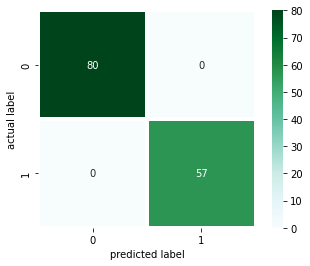

In [ ]:
# impliment grid search to find the optimal k-value
# load the KNN model
model = KNeighborsClassifier()

# implementation of grid search to find the optimal k-value
parameters = [{'n_neighbors': [3, 5,7,10]}]
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(train_features,labels)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#Printing the output of the 'best_parameters' object
print('Optimal k-value : ', best_parameters)

#Load the model with the best parameters obtained after grid search
knn_model = KNeighborsClassifier(n_neighbors = best_parameters.get('n_neighbors'))

# cross validation score
cross_val_knn = cross_val_score(knn_model, train_features,labels, cv=10)
print('Cross validation score : ',cross_val_knn.mean())

#Fit the model with training dataset
knn_model.fit(train_features,labels)

# prediction on validation dataset
y_predicted1 = knn_model.predict(validation_features)

# accuracy check on validation dataset
print("Accuracy : {:.2f}%".format(metrics.accuracy_score(labels_val, y_predicted1)*100))

# F1 Score
f1_score_KNN = metrics.f1_score(labels_val, y_predicted1, average='micro')
print("F1 score : {:.2f}".format(f1_score_KNN))

# recall 
recall_KNN = metrics.recall_score(labels_val, y_predicted1)
print("recall : {:.2f}".format(recall_KNN))

# precision
precision_KNN = metrics.precision_score(labels_val, y_predicted1)
print("precision : {:.2f}".format(precision_KNN))

# confusion martrix
cm_KNN = metrics.confusion_matrix(labels_val, y_predicted1)
# heatmap confusion matrix 
sns.heatmap(cm_KNN, annot=True, fmt=".0f", linewidths=3, square=True, cmap='BuGn', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')

plt.show()

In [ ]:
# prediction on test dataset
prediction = knn_model.predict([test_features[1]])
if prediction == [0]:
  print('Real')
else:
  print('Fake')

Real


# **SVM**

Optimal kernel :  {'kernel': 'rbf'}
Cross validation score :  0.9990909090909093
Accuracy of SVM Algorithm:  100.00%
F1 score : 1.00
recall : 1.00
precision : 1.00


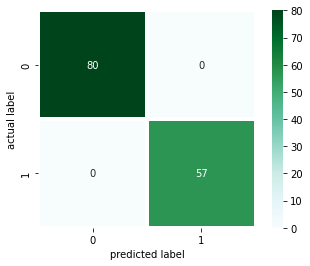

In [30]:
# load the SVM model
model = SVC()

# implementation of grid search to find the optimal kernel
parameters = [{'kernel': ['linear', 'rbf']}]
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(train_features,labels)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

#Printing the output of the 'best_parameters' object
print('Optimal kernel : ', best_parameters)

svm_model = SVC(kernel=best_parameters.get('kernel'))
# cross validation score
cross_val_svm = cross_val_score(svm_model, train_features,labels, cv=10)
print('Cross validation score : ',cross_val_svm.mean())
# fitting features and labels
svm_model.fit(train_features,labels)

# prediction on validation dataset
y_predicted2 = svm_model.predict(validation_features)
print('Accuracy of SVM Algorithm:  {:.2f}%'.format(metrics.accuracy_score(labels_val, y_predicted2)*100))

# F1 Score
f1_score_SVM = metrics.f1_score(labels_val, y_predicted2, average='micro')
print("F1 score : {:.2f}".format(f1_score_SVM))

# recall 
recall_SVM = metrics.recall_score(labels_val, y_predicted2)
print("recall : {:.2f}".format(recall_SVM))

# precision
precision_SVM = metrics.precision_score(labels_val, y_predicted2)
print("precision : {:.2f}".format(precision_SVM))

# confusion martrix
cm_SVM = metrics.confusion_matrix(labels_val, y_predicted2)
# heatmap confusion matrix 
sns.heatmap(cm_SVM, annot=True, fmt=".0f", linewidths=3, square=True, cmap='BuGn', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')

plt.show()

In [ ]:
# prediction test dataset
prediction=svm_model.predict([test_features[100]])
if prediction == [0]:
  print('Real')
else:
  print('Fake')

Fake


# **Random Forest**

Cross validation score :  0.9899833194328608
Accuracy of Random Forest Algorithm:  100.00%
F1 score : 1.00
recall : 1.00
precision : 1.00


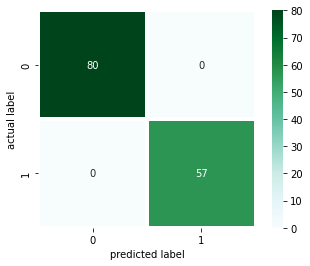

In [ ]:
# Load the Random Forest Classifier model
rfc_model = RandomForestClassifier()
# cross validation score
cross_val_rfc = cross_val_score(rfc_model, train_features,labels, cv=10)
print('Cross validation score : ',cross_val_rfc.mean())
# fitting the model on the training datset
rfc_model.fit(train_features,labels)

# prediction on vlidation datset
y_predicted3 = rfc_model.predict(validation_features)
print('Accuracy of Random Forest Algorithm:  {:.2f}%' .format(metrics.accuracy_score(labels_val, y_predicted3)*100))

# F1 Score
f1_score_RFC = metrics.f1_score(labels_val, y_predicted3, average='micro')
print("F1 score : {:.2f}".format(f1_score_RFC))

# recall 
recall_RFC = metrics.recall_score(labels_val, y_predicted3)
print("recall : {:.2f}".format(recall_RFC))

# precision
precision_RFC = metrics.precision_score(labels_val, y_predicted3)
print("precision : {:.2f}".format(precision_RFC))

# confusion martrix
cm_RFC = metrics.confusion_matrix(labels_val, y_predicted3)
# heatmap confusion matrix 
sns.heatmap(cm_RFC, annot=True, fmt=".0f", linewidths=3, square=True, cmap='BuGn', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')

plt.show()

In [ ]:
# predictions on test dataset
prediction = rfc_model.predict([test_features[120]])
if prediction == [0]:
  print('Real')
else:
  print('Fake')

Fake


# **Logistic Regression**

Cross validation score :  0.9690408673894911
Accuracy of Logistic Regression Algorithm: 94.16%
F1 score : 0.94
recall : 0.98
precision : 0.89


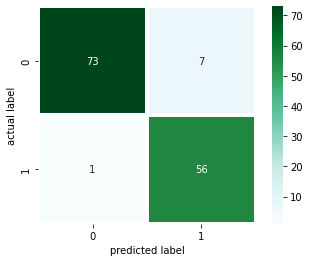

In [ ]:
# load the Logistic Regression model
log_model = LogisticRegression()

# cross validation score
cross_val_log = cross_val_score(log_model, train_features, labels, cv=10)
print('Cross validation score : ',cross_val_log.mean())

# fitting data
log_model.fit(train_features, labels)

# Predicted data
y_predicted4 = log_model.predict(validation_features)

# Accuarcy score matrix
print('Accuracy of Logistic Regression Algorithm: {:.2f}%'.format(metrics.accuracy_score(labels_val, y_predicted4)*100))

# F1 Score
f1_score_LR = metrics.f1_score(labels_val, y_predicted4, average='micro')
print("F1 score : {:.2f}".format(f1_score_LR))

# recall 
recall_LR = metrics.recall_score(labels_val, y_predicted4)
print("recall : {:.2f}".format(recall_LR))

# precision
precision_LR = metrics.precision_score(labels_val, y_predicted4)
print("precision : {:.2f}".format(precision_LR))

# confusion martrix
cm_LR = metrics.confusion_matrix(labels_val, y_predicted4)
# heatmap confusion matrix 
sns.heatmap(cm_LR, annot=True, fmt=".0f", linewidths=3, square=True, cmap='BuGn', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')

plt.show()

# **Naive Bayes**

The predictors take up a continuous value and are not discrete, hence a from of a gaussian distribution. Which is why, Gausian NB is implemented.

Cross validation score :  0.8524687239366138
Accuracy of Naive Bayes Algorithm: 81.75%
F1 score : 0.82
recall : 0.79
precision : 0.78


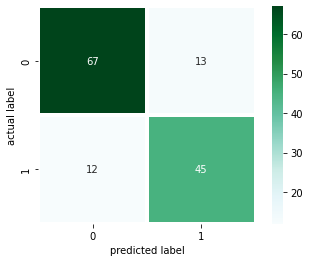

In [ ]:
# load the Naive Bayes model
gnb_model = GaussianNB()


# cross validation score
cross_val_gnb = cross_val_score(gnb_model, train_features, labels, cv=10)
print('Cross validation score : ',cross_val_gnb.mean())

# fitting training data
gnb_model.fit(train_features, labels)

# prediction on validation dataset
y_predicted5 = gnb_model.predict(validation_features)

# Accuracy Score 
print('Accuracy of Naive Bayes Algorithm: {:.2f}%'.format(metrics.accuracy_score(labels_val, y_predicted5)*100))

# F1 Score
f1_score_NB = metrics.f1_score(labels_val, y_predicted5, average='micro')
print("F1 score : {:.2f}".format(f1_score_NB))

# recall 
recall_NB = metrics.recall_score(labels_val, y_predicted5)
print("recall : {:.2f}".format(recall_NB))

# precision
precision_NB = metrics.precision_score(labels_val, y_predicted5)
print("precision : {:.2f}".format(precision_NB))

# confusion martrix
cm_NB = metrics.confusion_matrix(labels_val, y_predicted5)
# heatmap confusion matrix 
sns.heatmap(cm_NB, annot=True, fmt=".0f", linewidths=3, square=True, cmap='BuGn', color="#cd1076")
plt.ylabel('actual label')
plt.xlabel('predicted label')

plt.show()

#**Comparison between Algorithms by Recall, Precision, cross-validation and F1 Score**

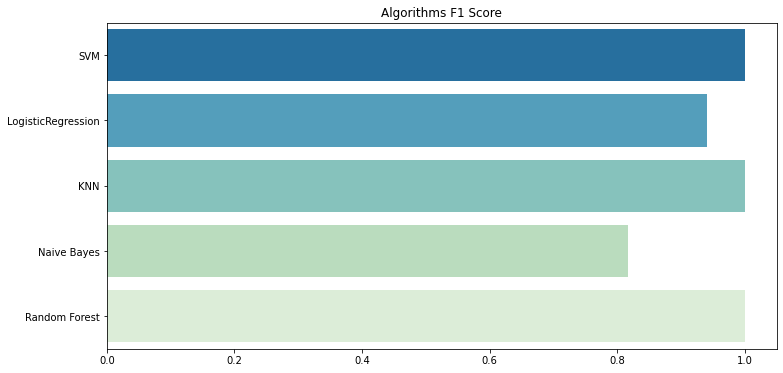

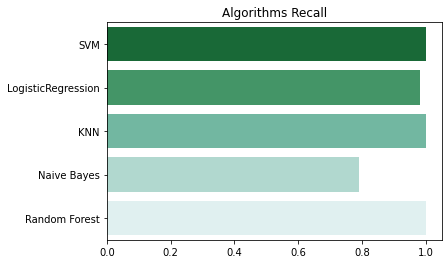

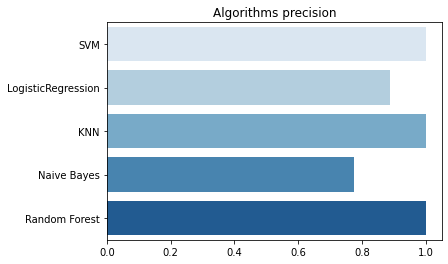

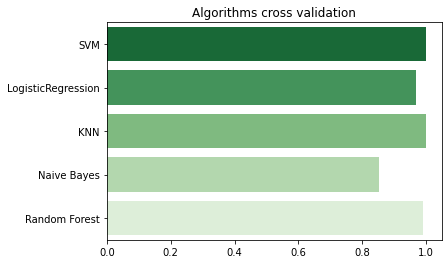

In [ ]:
plt.figure(figsize=(12, 6))
model_f1_score = [f1_score_SVM, f1_score_LR, f1_score_KNN, f1_score_NB, f1_score_RFC]
recalls = [recall_SVM, recall_LR, recall_KNN, recall_NB, recall_RFC]
precision = [precision_SVM, precision_LR, precision_KNN, precision_NB, precision_RFC]
cross_val = [cross_val_svm.mean(), cross_val_log.mean(), cross_val_knn.mean(), cross_val_gnb.mean(), cross_val_rfc.mean()]
model_name = ['SVM', 'LogisticRegression', 'KNN', 'Naive Bayes', 'Random Forest']

# Barplot f1 score
sns.barplot(x=model_f1_score, y=model_name, palette='GnBu_r')
plt.title('Algorithms F1 Score')
plt.show()

print('\n')
# barplot recall 
sns.barplot(x=recalls, y=model_name, palette='BuGn_r')
plt.title('Algorithms Recall')
plt.show()


print('\n')
# barplot precision score 
sns.barplot(x=precision, y=model_name, palette='Blues')
plt.title('Algorithms precision')
plt.show()

print('\n')
# barplot cross valiadation score 
sns.barplot(x=cross_val, y=model_name, palette='Greens_r')
plt.title('Algorithms cross validation')
plt.show()